# Notebook to serve as example of how to use polaraveraging
### created by Mijin & Marina & the CLMM team
################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
import clmm 


In [2]:
import sys
sys.path.append('./support')
import mock_data as mock
from astropy.cosmology.core import FlatLambdaCDM 

### Read in the data (here cosmoDC2)

In [3]:
acosmo = FlatLambdaCDM(H0=70., Om0=0.3, Ob0=0.025)
cosmo = modeling.cclify_astropy_cosmo(acosmo)


## Generating cluster object with mock data

#### Preparing config for mock data generation

Mock data will include shape noise, galaxies from redshift distribution and a pdz for each galaxies

In [4]:
config={}
config['cluster_id'] = 'mock cluster'
config['cluster_m'] = 1.e15
config['cluster_z'] = 0.3
config['src_z'] = 0.8
config['concentration'] = 4
config['ngals'] = 100000
config['Delta'] = 200
config['cosmo'] = cosmo

noisy_data_z = mock.MockData(config=config)
noisy_data_z.generate(is_shapenoise=True, is_zdistribution=True, is_zerr=True)

#### Loading this into a CLMM cluster object

In [5]:
# At the moment mock data only allow for a cluster centred on (0,0)
cluster_ra = 0.0
cluster_dec = 0.0
gc_object = gc.GalaxyCluster(config['cluster_id'], cluster_ra, cluster_dec, 
                             config['cluster_z'], noisy_data_z.catalog)
#gc_object.save("GC_from_mock_data.pkl")

## Load cluster object

In [6]:
#the cluster object contains properties of the lens: ra_l, dec_l, z_l and that of the sources : ra_s, dec_s, e1, e1 
#cl = gc.load_cluster("GC_from_mock_data.pkl")
cl = gc_object
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec, "; z_l :", cl.z)
print ("The number of source galaxies is :", len(cl.galcat))

Cluster info = ID: mock cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 100000


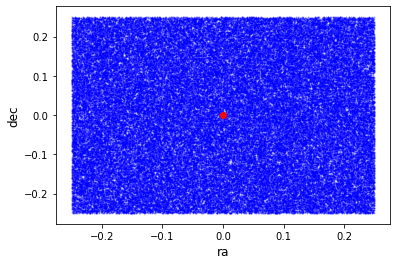

In [7]:
#plot cluster and galaxy positions
cl.galcat['ra'] = cl.galcat['ra']*10**6
cl.galcat['dec'] = cl.galcat['dec']*10**6

plt.scatter(cl.galcat['ra'],cl.galcat['dec'] ,color = 'blue',s= 1, alpha=0.3)
plt.plot(cl.ra,cl.dec, 'ro')
plt.ylabel('dec', fontsize = "large")
plt.xlabel('ra',fontsize = "large");

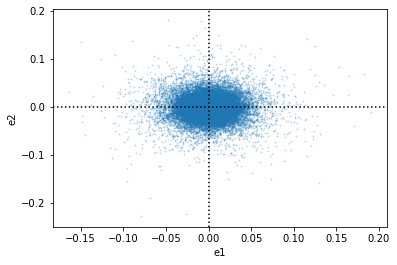

In [8]:
#check the ellipticities
fig, ax1 = plt.subplots(1,1)

ax1.scatter(cl.galcat['e1'],cl.galcat['e2'], s = 1, alpha = 0.2)
ax1.set_xlabel('e1')
ax1.set_ylabel('e2');
ax1.axvline(0, linestyle = 'dotted', color ='black')
ax1.axhline(0, linestyle = 'dotted', color ='black')

## Compute and plot shear profiles

In [9]:
# calculate angular separation and tangential shear and cross shear for each source galaxy
theta, g_t , g_x = pa.compute_shear(cl, geometry = "flat")


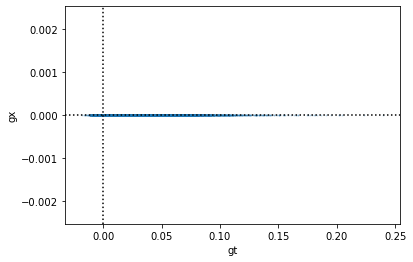

In [10]:
#check the shear, now the shear can be accessed through the cluster object
fig, ax1 = plt.subplots(1,1)

ax1.scatter(cl.galcat['gt'],cl.galcat['gx'], s = 1, alpha = 0.2) 
ax1.set_xlabel('gt')
ax1.set_ylabel('gx');
ax1.axvline(0, linestyle = 'dotted', color ='black')
ax1.axhline(0, linestyle = 'dotted', color ='black')

(array([4.5900e+02, 2.6155e+04, 5.1923e+04, 1.3920e+04, 4.1840e+03,
        1.7380e+03, 7.4600e+02, 4.0000e+02, 1.9600e+02, 1.3500e+02,
        5.7000e+01, 3.4000e+01, 2.2000e+01, 1.1000e+01, 7.0000e+00,
        6.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.01796055, -0.00507693,  0.00780669,  0.02069031,  0.03357393,
         0.04645754,  0.05934116,  0.07222478,  0.0851084 ,  0.09799202,
         0.11087564,  0.12375926,  0.13664287,  0.14952649,  0.16241011,
         0.17529373,  0.18817735,  0.20106097,  0.21394459,  0.2268282 ,
         0.23971182]),
 <a list of 20 Patch objects>)

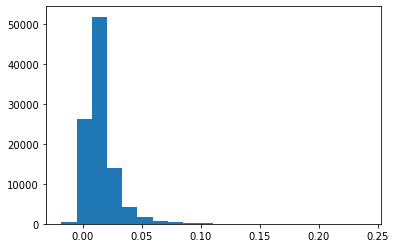

In [11]:
plt.hist(cl.galcat['gt'],bins=20)

In [21]:
#compute transversal and cross shear profiles in units defined by user, using defaults binning 
tab = pa.make_shear_profile(cl, "Mpc", bins=None, cosmo = acosmo)

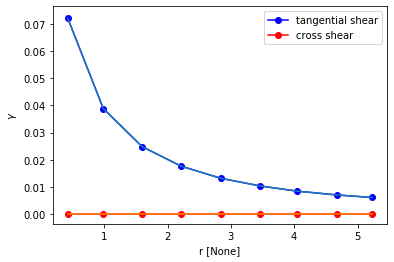

In [16]:
pa.plot_profiles(cl);

In [22]:
#define bins
new_bins = pa.make_bins(1, 4,20) 

#compute transversal and cross shear profiles in units defined by user, using binning defined by user
new_tab = pa.make_shear_profile(cl, "Mpc", bins=new_bins, cosmo = acosmo)

#BE CAREFULL BECAUSE THIS OVERWRITE THE CLUSTER OBJECT (better implementation will be done latter)

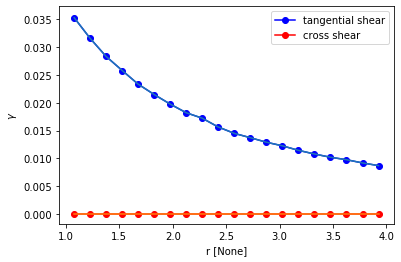

In [25]:
fig, ax = pa.plot_profiles(cl,"Mpc")

## You can also access the profiles quantities and play with them

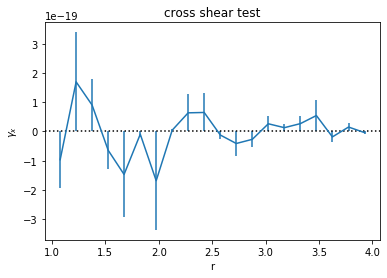

In [24]:
plt.title('cross shear test')
plt.errorbar(new_tab['radius'],new_tab['gx'],new_tab['gx_err'])
plt.title('cross shear test')
#plt.ylim(-0.002,0.002)
plt.axhline(0, linestyle = 'dotted', color = 'black')
plt.xlabel("r")
plt.ylabel('$\\gamma_x$');